In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


wandb: Currently logged in as: mhrnciar (nsiete-hrnciar-katkovcin). Use `wandb login --relogin` to force relogin


True

In [2]:
run = wandb.init(project="convolutional-nn", id="conv-layers-3-small-dataset")
wandb.config.update(config)

In [3]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')

In [4]:
data_path = 'Data/animals'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/animals',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/animals',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-04 16:57:39.368512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 16:57:39.368626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


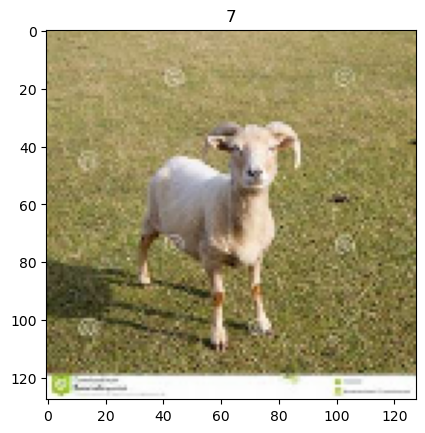

In [7]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [17]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)       

In [18]:
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[WandbCallback()])

Epoch 1/10


2023-04-04 16:59:44.602185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 1.6656 - sparse_categorical_accuracy: 0.4194 - sparse_categorical_crossentropy: 1.6656 - accuracy: 0.4194

2023-04-04 17:00:07.821177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 26s 39ms/step - loss: 1.6656 - sparse_categorical_accuracy: 0.4194 - sparse_categorical_crossentropy: 1.6656 - accuracy: 0.4194 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.5471 - val_sparse_categorical_crossentropy: 1.3233 - val_accuracy: 0.5471
Epoch 2/10
655/655 [==============================] - 26s 39ms/step - loss: 1.1990 - sparse_categorical_accuracy: 0.5953 - sparse_categorical_crossentropy: 1.1990 - accuracy: 0.5953 - val_loss: 1.1401 - val_sparse_categorical_accuracy: 0.6139 - val_sparse_categorical_crossentropy: 1.1401 - val_accuracy: 0.6139
Epoch 3/10
655/655 [==============================] - 25s 39ms/step - loss: 0.9434 - sparse_categorical_accuracy: 0.6846 - sparse_categorical_crossentropy: 0.9434 - accuracy: 0.6846 - val_loss: 1.0693 - val_sparse_categorical_accuracy: 0.6525 - val_sparse_categorical_crossentropy: 1.0693 - val_accuracy: 0.6525
Epoch 4/10
655/655 [==============================] - 26s 40ms/step - loss:

In [19]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,accuracy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,val_accuracy
0,1.665624,0.419404,1.665624,0.419404,1.323292,0.547087,1.323292,0.547087
1,1.199024,0.595302,1.199024,0.595302,1.140112,0.613945,1.140112,0.613945
2,0.943409,0.684635,0.943409,0.684635,1.069261,0.652531,1.069261,0.652531
3,0.733357,0.752626,0.733357,0.752626,1.083056,0.654441,1.083056,0.654441
4,0.525937,0.824389,0.525937,0.824389,1.215977,0.646036,1.215977,0.646036
5,0.346947,0.884836,0.346947,0.884836,1.360146,0.637249,1.360146,0.637249
6,0.217954,0.929383,0.217954,0.929383,1.533225,0.636867,1.533225,0.636867
7,0.148655,0.953352,0.148655,0.953352,1.886812,0.645081,1.886812,0.645081
8,0.106732,0.964524,0.106732,0.964524,2.071798,0.639733,2.071798,0.639733
9,0.087406,0.972689,0.087406,0.972689,2.294232,0.624833,2.294232,0.624833


In [20]:
model.evaluate(val_ds)

164/164 [==============================] - 2s 14ms/step - loss: 2.2942 - sparse_categorical_accuracy: 0.6248 - sparse_categorical_crossentropy: 2.2942 - accuracy: 0.6248


[2.29423189163208, 0.6248328685760498, 2.29423189163208, 0.6248328685760498]

In [21]:
tf.keras.models.save_model(model, "model/conv-layers-3-small-dataset.pth")
wandb.save('runs/pima_run_2023-04-04-conv-layers-3-small-dataset')
wandb.finish()

INFO:tensorflow:Assets written to: model/conv-layers-3-small-dataset.pth/assets


INFO:tensorflow:Assets written to: model/conv-layers-3-small-dataset.pth/assets


accuracy,▁▃▄▅▆▇▇███
loss,█▆▅▄▃▂▂▁▁▁
sparse_categorical_accuracy,▁▃▄▅▆▇▇███
sparse_categorical_crossentropy,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▅██▇▇▇▇▇▆
val_loss,▂▁▁▁▂▃▄▆▇█
val_sparse_categorical_accuracy,▁▅██▇▇▇▇▇▆
val_sparse_categorical_crossentropy,▂▁▁▁▂▃▄▆▇█
accuracy,0.97269
loss,0.08741
sparse_categorical_accuracy,0.97269
